# High-Dimensional Time Series Forecasting with Convolutional Neural Networks: Full-Fledged WaveNet    

Here's a section breakdown of this notebook

**1. Loading and Previewing the Data**   
**2. Formatting the Data for Modeling**  
**3. Building the Model - Training Architecture**  
**4. Building the Model - Inference Loop**  
**5. Generating and Plotting Predictions**

## 1. Loading and Previewing the Data 


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/solar_irradiation_data.csv')
df.head()

,Time,Timezone,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,RAIN_SUM
0,2019-07-01 00:00:00,ACST,-1.251141,-1.681195,226.046751,0.270745,4.599429,49.373845,0.0
1,2019-07-01 01:00:00,ACST,-1.105491,-1.564169,231.856001,0.438133,3.880017,50.883139,0.0
2,2019-07-01 02:00:00,ACST,-1.110939,-1.588327,235.262640,0.391107,3.119183,53.990385,0.0
3,2019-07-01 03:00:00,ACST,-0.995637,-1.483157,246.829333,0.444790,3.146530,54.673470,0.0
4,2019-07-01 04:00:00,ACST,-1.001849,-1.464027,249.490834,0.454146,5.106388,48.845702,0.0


In [ ]:
# ONLY RUN WHEN THE DATASET IS BEING USED DIRECTLY
df1 = df.copy()
df1['TIME'] = pd.to_datetime(df1['Time'])
df1['hour'] = df1['TIME'].dt.hour

df1.drop(['Timezone'], axis = 1, inplace = True)
df1.drop(['RAIN_SUM'], axis = 1, inplace = True)
df1.drop(['TIME'],axis =1, inplace = True)

df1 = df1.dropna(subset = ['GHI_AVG'])

# About the Nan and -ve values, cause it creates an issue
df1.loc[(df1['GHI_AVG'] < 0) | (df1['DNI_AVG'] < 0) | (df1['WDIR_AVG']<0) | (df1['WSPD_AVG']<0) | (df1['TEMP_AVG']<0) | (df1['HUM_AVG']<0), ['GHI_AVG', 'DNI_AVG', 'WDIR_AVG', 'WSPD_AVG','TEMP_AVG', 'HUM_AVG', 'RAIN_SUM']] = 0

df1

,Time,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,hour,RAIN_SUM
0,2019-07-01 00:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0
1,2019-07-01 01:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0.0
2,2019-07-01 02:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2,0.0
3,2019-07-01 03:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3,0.0
4,2019-07-01 04:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4,0.0
...,...,...,...,...,...,...,...,...,...
27809,2022-09-01 17:00:00,28.101389,0.0,145.524306,1.942893,12.795519,95.269921,17,NaN
27810,2022-09-01 18:00:00,0.883333,0.0,136.775139,1.787685,12.445601,98.542388,18,NaN
27811,2022-09-01 19:00:00,0.000000,0.0,135.269583,2.099801,11.979293,99.854972,19,NaN
27812,2022-09-01 20:00:00,0.000000,0.0,129.577778,0.919404,11.599545,99.721071,20,NaN


In [ ]:
dft = df1.set_index('Time').T.reset_index(drop=False)
dft

Time,index,2019-07-01 00:00:00,2019-07-01 01:00:00,2019-07-01 02:00:00,2019-07-01 03:00:00,2019-07-01 04:00:00,2019-07-01 05:00:00,2019-07-01 06:00:00,2019-07-01 07:00:00,2019-07-01 08:00:00,...,2022-09-01 12:00:00,2022-09-01 13:00:00,2022-09-01 14:00:00,2022-09-01 15:00:00,2022-09-01 16:00:00,2022-09-01 17:00:00,2022-09-01 18:00:00,2022-09-01 19:00:00,2022-09-01 20:00:00,2022-09-01 21:00:00
0,GHI_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.691893,205.014492,...,171.306944,146.815278,397.580556,120.298611,99.322222,28.101389,0.883333,0.000000,0.000000,0.000000
1,DNI_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.923585,702.892465,...,0.000000,0.000000,42.477778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,WDIR_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173.649389,194.149584,...,107.092917,106.599028,98.092639,143.875417,141.260417,145.524306,136.775139,135.269583,129.577778,145.930000
3,WSPD_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.563628,1.109589,...,1.056710,1.626819,2.646124,1.976757,1.864640,1.942893,1.787685,2.099801,0.919404,0.739417
4,TEMP_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.970904,13.686888,...,10.964323,11.592841,12.566402,12.903492,12.915450,12.795519,12.445601,11.979293,11.599545,11.415985
5,HUM_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.616153,28.857826,...,99.881789,99.856209,98.669837,96.680905,95.157149,95.269921,98.542388,99.854972,99.721071,99.879030
6,hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.000000,8.000000,...,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,21.000000
7,RAIN_SUM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Columns: 25843 entries, index to 2022-09-01 21:00:00
dtypes: float64(25842), object(1)
memory usage: 1.6+ MB


In [ ]:
data_start_date = dft.columns[1]
data_end_date = dft.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2019-07-01 00:00:00 to 2022-09-01 21:00:00


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

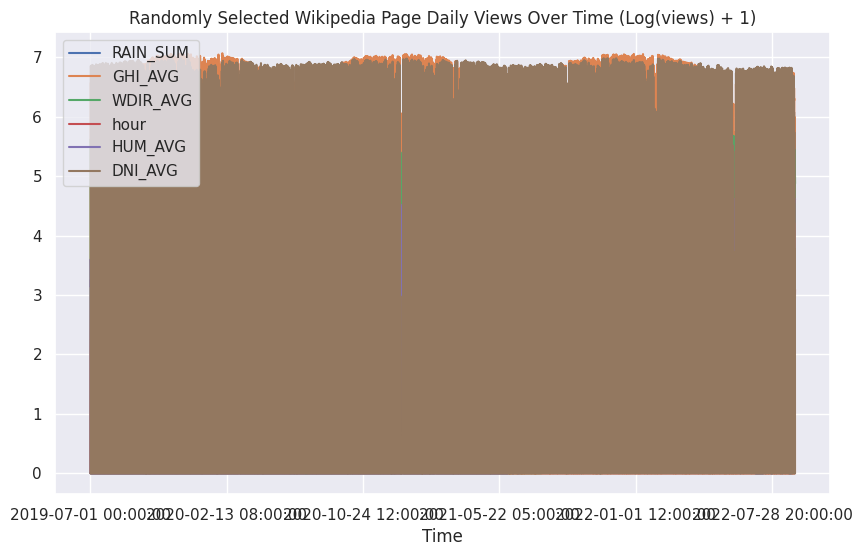

In [ ]:
def plot_random_series(df, n_series):
    
    sample = dft.sample(n_series, random_state=8)
    # sample
    page_labels = sample['index'].tolist()
    # page_labels
    series_samples = sample.loc[:,data_start_date:data_end_date]
    # series_samples

    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

## 2. Formatting the Data for Modeling 

Sadly we can't just throw the dataframe we've created into keras and let it work its magic. Instead, we have to set up a few data transformation steps to extract nice numpy arrays that we can pass to keras. But even before doing that, we have to know how to appropriately partition the time series into encoding and prediction intervals for the purposes of training and validation. Note that for our simple convolutional model we won't use an encoder-decoder architecture , but **we'll keep the "encoding" and "decoding" (prediction) terminology to be consistent** -- in this case, the encoding interval represents the entire series history that we will use for the network's feature learning, but not output any predictions on. 

### Train and Validation Series Partioning

We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 60 days)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 60 days)


In [ ]:
from datetime import timedelta

pred_steps = 24 * 7 
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(hours = 1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(hours = 1) 

NameError: ignored

In [ ]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(hours = 1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(hours = 1) 

In [ ]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2019-07-01 00:00:00 - 2022-08-18 21:00:00
Train prediction: 2022-08-18 22:00:00 - 2022-08-25 21:00:00 

Val encoding: 2019-07-08 00:00:00 - 2022-08-25 21:00:00
Val prediction: 2022-08-25 22:00:00 - 2022-09-01 21:00:00

Encoding interval: 1144
Prediction interval: 7


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 

In [ ]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in dft.columns[1:]]),
                          data=[i for i in range(len(dft.columns[1:]))])

series_array = dft[dft.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

## 3. Building the Model - Architecture

The model also utilizes some other key techniques: **gated activations**, **residual connections**, and **skip connections**. 
### **Our Architecture**

With all of our components now laid out, here's what we'll use:

* 16 dilated causal convolutional blocks
    * Preprocessing and postprocessing (time distributed) fully connected layers (convolutions with filter width 1): 16 output units
    * 32 filters of width 2 per block
    * Exponentially increasing dilation rate with a reset (1, 2, 4, 8, ..., 128, 1, 2, ..., 128) 
    * Gated activations
    * Residual and skip connections
* 2 (time distributed) fully connected layers to map sum of skip outputs to final output 

We'll extract the last 24*7(last week) steps from the output sequence as our predicted output for training. We'll use teacher forcing again during training. Similarly to the previous notebook, we'll have a separate function that runs an inference loop to generate predictions on unseen data, iteratively filling previous predictions into the history sequence. 

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam # ........................................................................................................

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 3))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':168})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error',metrics=['mae']) # .................................................................

In [ ]:
from keras.utils.vis_utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 conv1d_132 (Conv1D)            (None, None, 16)     64          ['input_3[0][0]']                
                                                                                                  
 conv1d_133 (Conv1D)            (None, None, 32)     1056        ['conv1d_132[0][0]']             
                                                                                                  
 conv1d_134 (Conv1D)            (None, None, 32)     1056        ['conv1d_132[0][0]']             
                                                                                            

In [57]:
df = pd.read_csv('/content/gdrive/MyDrive/solar_irradiation_data.csv')
df = df.dropna(subset = ['GHI_AVG', 'TEMP_AVG', 'HUM_AVG'])
df.describe()

,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,RAIN_SUM
count,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000
mean,261.468428,305.604844,174.510184,1.388757,21.421420,38.827830,38776.075753
std,350.681499,398.681049,75.716074,4.424704,9.321068,22.312720,103696.380212
min,-6.350522,-4.650700,0.000000,0.000000,-4.173657,4.267947,0.000000
25%,-0.636510,-1.356412,120.185135,0.384553,14.878512,21.659492,0.000000
50%,6.630593,0.000000,161.973918,1.152047,21.852783,33.345202,0.000000
75%,548.069702,767.101214,243.644972,2.155846,28.335655,51.553219,6192.000000
max,1170.911090,1076.749711,700.014391,652.826218,44.854888,99.932081,429120.000000


In [88]:
import random
def create_dataset(X,batch_size,time_steps=1,pred_steps=1):
  Xs,ys = [],[]
  for i in range(batch_size):
    idx = random.randint(0,len(X)-time_steps-pred_steps)
    v = X[idx:idx+time_steps, :]
    u = X[idx+time_steps:idx+time_steps+pred_steps, :]
    Xs.append(v)
    ys.append(u)
  return np.array(Xs), np.array(ys)

In [89]:
from sklearn.preprocessing import MinMaxScaler
def scaler(data):
  scaler = MinMaxScaler(feature_range=(0,1))
  data_use = scaler.fit_transform(data)
  return data_use

In [92]:
df['TIME'] = pd.to_datetime(df['Time'])
df['hour'] = df['TIME'].dt.hour
data_use = scaler(df.iloc[:,[2]])
X = data_use

time_steps = 24*7*4
pred_steps = 24*7*1
X_data, y_data = create_dataset(np.array(X),100,time_steps,pred_steps)

In [95]:
X_data.shape

(100, 672, 1)

In [80]:
y_data.shape

(672, 1, 1)

In [ ]:
# L = len(X_data)
# X_train = X_data[0:int(L*0.8)]
# y_train = y_data[0:int(L*0.8)]
# X_test = X_data[int(L*0.8):]
# y_test = y_data[int(L*0.8):]

In [ ]:
X_train.shape


(20136, 672, 3)

In [96]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 28 days time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':16})(x)

model = Model(history_seq, pred_seq_train)

In [97]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_17 (Conv1D)          (None, None, 32)          96        
                                                                 
 conv1d_18 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_19 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_20 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_21 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_22 (Conv1D)          (None, None, 32)          2080

With our training architecture defined, we're ready to train the model! This will take quite a while if you're not running fancy hardware (read GPU). We'll leverage the transformer utility functions we defined earlier, and train using mean absolute error loss.

Note that for this full-fledged model, we have more than twice as many total parameters to train as we did with the simpler WaveNet model, explaining the slower training time (along with using more training data). From the loss curve you'll see plotted below, it also seems likely that the model can continue to improve with more than 10 training epochs -- the more complex model probably needs additional time to reach its full potential. That said, from the results plots (see section 5) we can see that this full-fledged model is very capable of handling the 60-day forecast horizon and often can generate very expressive predictions. 

This is only a starting point, and I would encourage you to play around with this architecture to see if you can get even better results! You could try using more data, adjusting the hyperparameters, tuning the learning rate and number of epochs, etc.  

In [100]:
model.compile(Adam(), loss='mean_absolute_error')
model.fit(X_data,y_data, batch_size=10, epochs=20,validation_split=0.2)

Epoch 1/20


ValueError: ignored

In [14]:
from sklearn.metrics import r2_score
preds = x.predict(X_test)

158/158 [==============================] - 19s 110ms/step


In [ ]:
preds[1], y_test[1]

In [15]:
print(f"{r2_score(preds,y_test)}")

ValueError: ignored

In [ ]:
y_test

array([[ 0.],
       [ 0.],
       [42.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.]])

In [ ]:
first_n_samples = 7 # choose the right number of relateable 
batch_size = 12 # ideall yshould be 11
epochs = 10 # ideally replace with 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error') # .....................................................................
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)  

Epoch 1/10
1/1 [==============================] - 22s 22s/step - loss: 0.3395 - val_loss: 0.2572
Epoch 2/10
1/1 [==============================] - 8s 8s/step - loss: 0.3728 - val_loss: 0.3096
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.4298 - val_loss: 0.2118
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 0.3566 - val_loss: 0.2716
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.3582 - val_loss: 0.2991
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 0.3728 - val_loss: 0.2463
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.3393 - val_loss: 0.1971
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 0.3552 - val_loss: 0.2116
Epoch 9/10
1/1 [==============================] - 7s 7s/step - loss: 0.3658 - val_loss: 0.2126
Epoch 10/10
1/1 [==============================] - 5s 5s/step - loss: 0.3666 - val_loss: 0.2232


In [ ]:
decoder_target_data[0]

It's typically a good idea to look at the convergence curve of train/validation loss.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## 4. Building the Model - Inference Loop

In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

## 5. Generating and Plotting Predictions  

In [ ]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=5, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=4, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=0, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=0)

In [ ]:
model.predict(encoder_input_data[0])

InvalidArgumentError: ignored